# Preprocesamiento para Experimentos de Actividad Evocada

Este Cuaderno es básicamente una versión interactiva del programa en el archivo "SeparaActividadyPromedia.jl" que contiene las mismas rutinas pero automatizadas. Esta versión permite un poco más de interacción.

In [8]:
push!(LOAD_PATH, ".")
# en este modulo se encuentran las rutinas para encontrar los estimulos ("trancazos")
# y los canales saturados
using PreprocTools
using HDF5

┌ Info: Precompiling PreprocTools [top-level]
└ @ Base loading.jl:1192


In [9]:
# Nombre de un archivo *brw en formato hdf5 con datos de acticidad evocada
abrestring="/home/karel/ElectroNeuroTools/BRWFiles/050815_3R7_converted.brw"
stringgeneral=replace(abrestring, ".brw"=>"")  

"/home/karel/ElectroNeuroTools/BRWFiles/050815_3R7_converted"

In [10]:
#Todos los datos de la matriz del brw file
Datos=AbreyCheca(abrestring)

Dict{String,Any} with 8 entries:
  "minvolt"     => -4125.0
  "maxvolt"     => 4125.0
  "frecuencia"  => 7020.8
  "DatosCrudos" => UInt16[0x0000 0x0000 … 0x0000 0x0000; 0x0800 0x0809 … 0x07ed…
  "bitdepth"    => 0x0c
  "factor"      => -2.01416
  "numcuadros"  => 210624
  "duracion"    => 30.0

In [11]:
# Si los datos andan en un arreglo de lista en lugar de cuadrado, los ponemos cuadrados
if size(Datos["DatosCrudos"])[1] != 4096
DatosCrudosArreglados=reshape(Datos["DatosCrudos"], (4096, Datos["numcuadros"]))
else
DatosCrudosArreglados=Datos["DatosCrudos"]
end;


In [124]:
#parametetros globales.
freq=Datos["frecuencia"]/1000 #cuadros por milisegundo.
factor=Datos["factor"] #Factor de conversion de numeros enteros a microVolts
# todo lo siguiente esta en ms
retrazo=5
final=60
latencia=3
#Gis recomienda esperar hasta 6.5 ms por cada estimulo.
tiempopostgolpe=6.5


6.5

Tomamos un electrodo como ejemplo y buscamos los momentos (en cuadros, unidades enteras) de los estimulos:

In [125]:
ejemplo=vec(DatosCrudosArreglados[1500,:]);
listongas=EncuentraTrancazosRaw(ejemplo,500)
println("Sitios de trancazo electrico en cuadros =", listongas)

Sitios de trancazo electrico en cuadros =[47149, 117758, 188366]


Ahora creamos un diccionario que contenga la actividad alrededor de los estimulos

In [126]:
ActividadRaw=ActivAlrededorTrancazo(listongas, DatosCrudosArreglados, freq)
(bla,tmax)=size(ActividadRaw["Trancazo_1"])
println("Tiempo, en cuadros, de los intervalos con trancazo=",tmax)


Tiempo, en cuadros, de los intervalos con trancazo=459


Finalmente, centramos y  reescalamos los datos, y los promediamos.

In [127]:
DatosCentrados=Dict{AbstractString, Array}()
for k in keys(ActividadRaw)
    DatosCentrados[k]=FormaMatrizDatosCentrados(ActividadRaw[k], factor)
end
LFPPromedio=(DatosCentrados["Trancazo_1"]+DatosCentrados["Trancazo_2"]+DatosCentrados["Trancazo_3"])/3;

Eso fue la parte de promediar y poner escala sensible a los datos. Ahora prosigue detectar canales con respuesta fisiológica y canales saturados. Empecemos primero por las respuestas.

In [174]:
#los parametros son datos promediados, frecuencia, tiempo post estimulo en ms, umbral en microvolts, umbral de saturación en microvolts
iniciobusqueda=retrazo+latencia
finbusqueda=iniciobusqueda+tiempopostgolpe

PruebaRespuesta=BuscaCanalRespActPot(LFPPromedio,iniciobusqueda, 
    finbusqueda, freq, -120,-1500, 10, 180)
# y luego los saturados
#Saturados=BuscaSaturados(LFPPromedio,iniciobusqueda,finbusqueda)
#numerosaturados=length(Saturados)
println("Encontramos ", numerosaturados, " canales probablemente saturados.")


Estoy buscando del cuadro 57 al , 102
Encontramos 230 canales probablemente saturados.


In [175]:
PruebaRespuesta

203×2 Array{Int64,2}:
 16  28
 17  28
 16  29
 17  29
 15  30
 16  30
 17  30
 15  31
 16  31
 17  31
 15  32
 16  32
 17  32
  ⋮    
 16  64
 17  64
 18  64
 31  64
 36  64
 37  64
 38  64
 39  64
 40  64
 43  64
 45  64
 47  64

In [176]:
dirname(stringgeneral), basename(stringgeneral)

("/home/karel/ElectroNeuroTools/BRWFiles", "050815_3R7_converted")

Finalmente podemos guardar los Datos

In [189]:
dirgen=dirname(stringgeneral)
basegen=basename(stringgeneral)
outname=string(dirgen,"/LFP_Promedio_", basegen, ".h5")
#aqui hay que arreglar el rollo del directorio
parametros=(freq, retrazo, latencia,final)
listaaguardar=Dict(
     "LFPSaturados"=>LFPPromedio,
     "freq" =>freq,
     "freq" => freq,
     "retrazo" => retrazo,
     "latencia" =>latencia,
     "final"=> final,
     "CanalesRespuesta"=>PruebaRespuesta,
     "CanalesSaturados" => Saturados)


println(outname )
   h5open(outname, "w")  do file
        for k in keys(listaaguardar)
            datos=listaaguardar[k]
            println("abriendo los datos ", k)
            println
            write(file, "$k", datos)
        end
    end

/home/karel/ElectroNeuroTools/BRWFiles/LFP_Promedio_050815_3R7_converted.h5
abriendo los datos CanalesSaturados
abriendo los datos latencia
abriendo los datos retrazo
abriendo los datos CanalesRespuesta
abriendo los datos LFPSaturados
abriendo los datos freq
abriendo los datos final


MethodError: MethodError: no method matching close(::String)
Closest candidates are:
  close(!Matched::Base.DevNull) at coreio.jl:15
  close(!Matched::IOStream) at iostream.jl:39
  close(!Matched::Base.Libc.FILE) at libc.jl:93
  ...

In [ ]:
outname

In [178]:
using Plots
gr()
clibraries()

5-element Array{Symbol,1}:
 :Plots      
 :cmocean    
 :misc       
 :colorcet   
 :colorbrewer

In [179]:
exlfp=LFPPromedio[:,:,77]
xr=PruebaRespuesta[:,2]
yr=PruebaRespuesta[:,1]
xs=Saturados[:,2]
ys=Saturados[:,1];

In [180]:
?clibraries()

```
clibraries()
```

List the available color libraries on the system


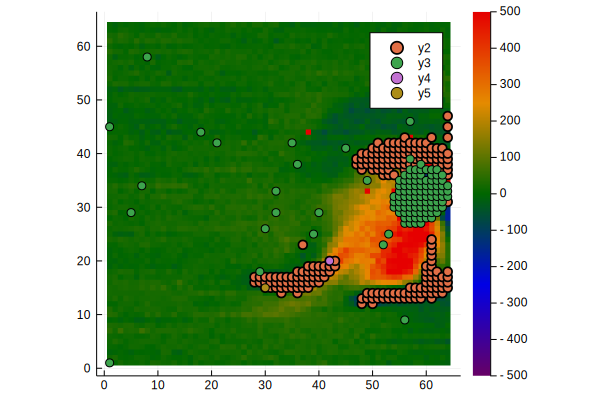

In [183]:
ppp=heatmap(exlfp, aspect_ratio=1, clims=(-500,500), color=:darkrainbow)
scatter!(ppp, xr, yr, key=false, markerstrokewidth=2)
scatter!(ppp, xs, ys)
scatter!(ppp, [42], [20], key=true)
scatter!(ppp, [30], [15], key=true)


In [182]:
exlfptrazo=LFPPromedio[20,42,:];
exlfptrazo2=LFPPromedio[15,30,:];


In [135]:
rangolfp=1:length(exlfptrazo)

1:459

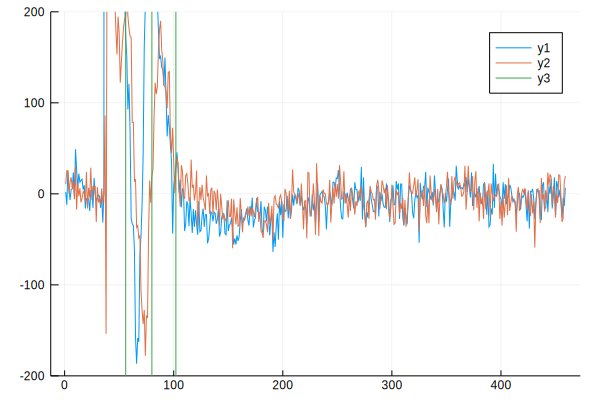

In [160]:
pp=plot(rangolfp, exlfptrazo, ylims=(-200,200))
pp=plot!(rangolfp, exlfptrazo2)

vline!(pp,[ini, ini+24, fin])

In [90]:
using Statistics

In [161]:
ini=round(Int64, iniciobusqueda*freq)
fin=round(Int64, finbusqueda*freq)

std(exlfptrazo2[ini+24:fin*2])

51.771620897656916

In [95]:
ini

35

In [96]:
fin

77

In [99]:
?vline

search: vline vline! violin! violin InvalidStateException



```
vline(x)
vline!(x)
```

Draw vertical lines at positions specified by the values in  the AbstractVector `x`

# Example

```julia-repl
julia> vline([-1,0,2])
```


In [107]:
factor

-2.01416015625